# Overall survival (OS) and progression free survival model (PFS)
**Goal**: Make a prediction model that, given certain input $𝑥$, generates a prediction $𝑦$. In the case at hand, $𝑦$ would be the overall survival (OS) or the progression free survival (PFS).

In the following, I will focus on OS -- results not shown here indicate that the entire analysis below goes through for PFS as well.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import mean_squared_error
import seaborn as sns

from fit import fit_categorical_survival, categorical_signal
from models import MergeRareCategories
from pipelines import benchmark_pipelines, build_regression_pipelines, categorical_input_columns, pipelines , reconstruct_categorical_variable_names_Richard
from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets, survival_histograms
from views import categorical_signal_summary, view_as_exponential, view_decision_tree_julian, view_linear_model_richard

Process files and split data in a part that is used for fitting (training) and for testing.

In [2]:
def harmonic_mean(t0, t1):
    return t0 * t1 / (t0 + t1)

In [3]:
load_process_and_store_spreadsheets(transformation=harmonic_mean)

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

In [4]:
# Combined set for analysis only (not to be used for models).
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Model

In [5]:
# Construct a variety of pipelines.
pipelines = build_regression_pipelines()

# And benchmark them using the root mean squared error.
rmse = lambda x, y: mean_squared_error(x, y) ** 0.5
benchmark_result = benchmark_pipelines(
    pipelines, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse
)

In [6]:
benchmark_result

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,331.221847,255.227153,381.503252,269.618643
RandomForestRegressor,321.659853,289.205408,287.635103,290.898249
GradientBoostingRegressor,289.469174,266.030076,302.617991,268.450157
KNeighborsRegressor,375.229392,289.899266,367.328402,313.401862
ElasticNet,259.423289,271.744500,273.215056,263.350630
LinearRegression,261.651308,260.780187,1942.032904,251.282592
SVR,277.045767,276.105578,277.044043,276.572572
DummyRegressor,277.072810,277.072810,277.072810,277.072810


Briefly, the types of models in this list:
- Decision tree: Consecutively split the data in two branches based on one of the variables.
- Random forest: collection of decision trees in parallel, each tree gets a subset of the training data.
- Gradient boosting: collection of decision trees in series, each refining the result of the previous tree.
- K-neighbours: Use average of $k$ neighbouring points.
- Elastic net: Linear regression with penalties on the slopes.
- SVR: Support vector machine that implicitly takes into account polynomials of the input variables.
- DummyRegressor: Baseline model that predicts according a specific rule (in this case, take the median value).

Pipelines:
- Richard: Use only phenotype data, and some categorical preprocessing.
- Julian: Convert mutation data to columns using transformation described above (harmonic mean).
- Freeman: Use all data together.
- Lev: Democratic vote of Richard & Julian.

## Factor analysis
Let us now look at which factors determine the outcome of the models.

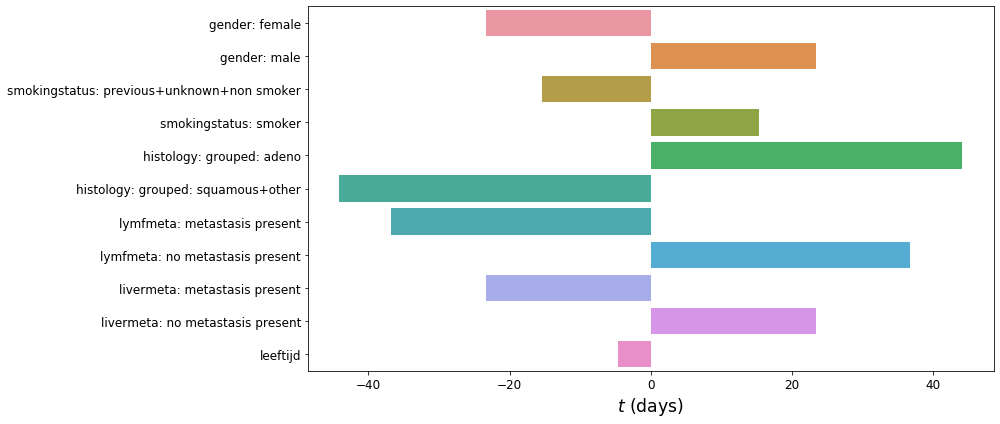

In [7]:
p_richard = pipelines['ElasticNet']['Richard']
view_linear_model_richard(pipeline=p_richard)

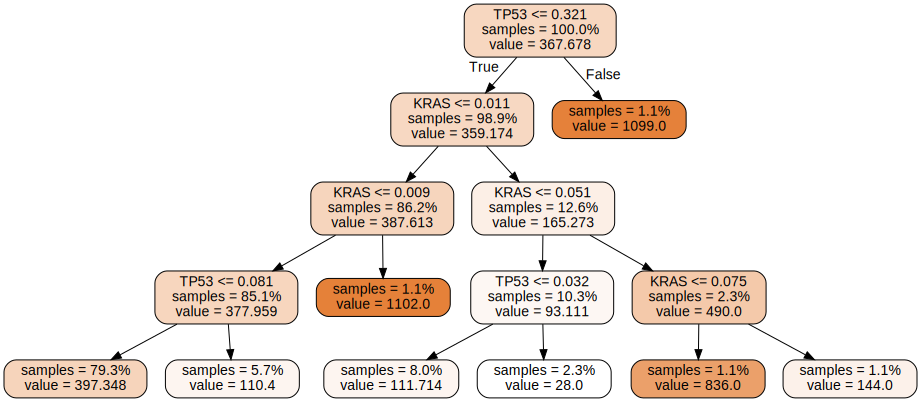

In [8]:
p_julian = pipelines['DecisionTreeRegressor']['Julian']
view_decision_tree_julian(p_julian)

## Conclusion
The models perform absolutely terrible, hardly better than the baseline model which does not use any of the variables to make predictions.

In [9]:
from pipelines import hybrid_regressor

In [10]:
p = hybrid_regressor()
p.fit(X_train, y_train['OS_days'])
y_train_pred = p.predict(X_train)
y_test_pred = p.predict(X_test)
rmse(y_test['OS_days'], y_test_pred)

251.56717796283016

# Data distribution
To understand better why the model works so terrible, let us look at the data distribution.
Calculate the histogram and the cumulative histogram of the data.

In [11]:
# Calculate the distribution of all the data, not just the training data.
(t_OS, p_OS), (t_OS_cum, p_OS_cum) = survival_histograms(y['OS_days'], hist_bins=10, cum_hist_bins=15)

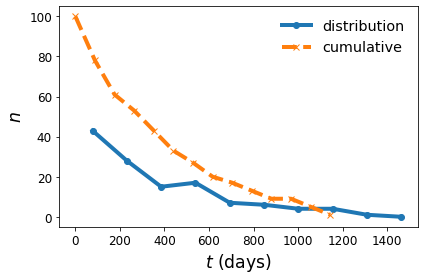

In [12]:
plt.plot(t_OS, p_OS, '-o', label='distribution')
plt.plot(t_OS_cum, p_OS_cum, '--x', label='cumulative')
plt.xlabel('$t$ (days)')
plt.ylabel('$n$')
plt.legend(frameon=False)

which clearly shows an exponentially decaying function (as a side note, if the original distribution is exponential, than so is the cumulative function). 

If patients indeed decay exponentially
$$N(t) = N_0 \exp\left(-\frac{t}{\tau}\ln 2\right) ,$$
then the half life $\tau$ can be determined from the slope
$$
\ln[N(t)] = -\frac{\ln 2}{\tau} t + \ln N_0.
$$
Let us fit this to the distribution:


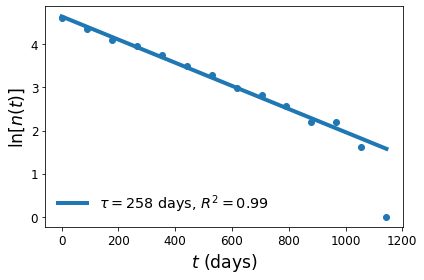

In [13]:
# The last datum is an outlier.
outliers = [len(p_OS_cum) - 1]
view_as_exponential(t_OS_cum, p_OS_cum, outlier_indices=outliers)

# Signal in the data
Clearly, the data has a significant statistical component. Just to remind you, in a perfect scenario there is no noise in the data and we can predict with certainty the outcome. That is,
$f(x) $
and our goal is to design a function $g(x)$ that is a good approximation of $f(x)$. Looking back at the figure above, this would mean that all of our statistical uncertainty derives from an incomplete specification of the conditions $x$. Or put differently, ideally all the statistical uncertainty can be resolved by $x$.

In reality, we may have incomplete knowledge, and this lack of knowledge introduces noise in the data. Therefore, in practice one has
$$
y = f(x) + \epsilon,$$
with $\epsilon$ some noise term. Since our prediction models work rather poorly, it seems that $\epsilon$ is a non-negligble part.

**Question**: How much of the noise can be accounted for using $x$?

In [14]:
# First merge all categories that occur less than 30 times.
X = MergeRareCategories(thresshold=30, categorical_columns=categorical_input_columns).fit_transform(X)

In [15]:
effect_summary = categorical_signal_summary(X, y['OS_days'], categorical_input_columns)
effect_summary

delta tau  \
category            item                                                             
gender              male-female                                          41.573833   
stage               4-3                                                  72.542822   
therapyline         2-1+3+0+4                                            34.609658   
smokingstatus       smoker-previous                                     126.921462   
                    smoker-unknown+non smoker                           166.779831   
                    previous-unknown+non smoker                          39.858369   
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...   40.112911   
histology_grouped   adeno-squamous                                       30.270218   
                    adeno-other                                          70.383545   
                    squamous-other                                      100.653763   
lymfmeta            metastasis present-no metastasis present            111.699710   
brainmeta           metastasis present-no metastasis present             33.175529   
adrenalmeta         no metastasis present-metastasis present             41.995421   
livermeta           no metastasis present-metastasis present             51.224007   
lungmeta            no metastasis present-metastasis present             19.664026   
skeletonmeta        no metastasis present-metastasis present              2.896052   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                0.135917  
stage               4-3                                                        0.237163  
therapyline         2-1+3+0+4                                                  0.113149  
smokingstatus       smoker-previous                                            0.414943  
                    smoker-unknown+non smoker                                  0.545251  
                    previous-unknown+non smoker                                0.130308  
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...         0.131141  
histology_grouped   adeno-squamous                                             0.098962  
                    adeno-other                                                0.230104  
                    squamous-other                                             0.329066  
lymfmeta            metastasis present-no metastasis present                   0.365178  
brainmeta           metastasis present-no metastasis present                   0.108460  
adrenalmeta         no metastasis present-metastasis present                   0.137295  
livermeta           no metastasis present-metastasis present                   0.167466  
lungmeta            no metastasis present-metastasis present                   0.064287  
skeletonmeta        no metastasis present-metastasis present                   0.009468

The largest effect is related to smoking.

In [16]:
i = effect_summary.idxmax(axis=0)
effect_summary.loc[i]

delta tau  signal to noise
category      item                                                  
smokingstatus smoker-unknown+non smoker  166.779831         0.545251
              smoker-unknown+non smoker  166.779831         0.545251

Even so, statistical noise overwhelms this contribution when only this effect is taken into account.

# Performance model
Using the analysis above alows us to do an analysis of the best-case and worst-case scenario that a perfect model can attain.
- Best case scenario: all contributions add meaning that we can resolve 

In [17]:
sum(effect_summary['delta tau'])

984.3611593161758

all of the noise, but requiring $2^{16} \approx 7 \cdot 10^4$ data points.

- Worst case scenario: improvement in prediction in one group undoes the improvement in all other groups and we are left with $\arg \max \Delta \tau(x)$.

## Theoretical lower bound on model performance
Assuming the worst case scenario, we can now derive a lower bound on the mean squared error, given that the data is distributed according to the exponentially decaying function.

Normalising $N(t) = N_0 e^{-t \ln 2 / \tau}$ to $p(t)$ gives 
$$
p(t) = \alpha e^{-\alpha t} ,
$$
with $\alpha = \ln 2/\tau$. The standard deviation is nothing but the root mean squared error of the average:
$$
\sigma_t^2 = \langle t^2 \rangle - \langle t \rangle^2 .
$$
Calculating the avarage $\langle t \rangle = 1/\alpha$ and the two point function $\langle t^2 \rangle= 2/\alpha^2$ allows one to express the standard deviation as.
$$
\sigma_t^2 = \alpha^{-2} = \left( \frac{\tau}{\ln 2} \right)^2 .
$$
Using the value above $\tau =258$ days gives a variance of

In [18]:
sigma_t = 258 / np.log(2)
print(f'{sigma_t:.2f}')

372.22


and so, with $\Delta \tau = 167$ we arive at $\sigma_t - \frac{\Delta \tau}{2} = $

In [19]:
delta_t = 167
min_mse = sigma_t - delta_t  /2
print(min_mse)

288.71532054935255


Meaning that, at least in theory, we should be able to get an estimate with a root mean squared error below this number. 

The fact that this number is quite close to the best performing models indicate that probably there is still room for improvement.